## Yield Spread model
This notebook implements a model to predict yield spreads from reference and trade history data. The model uses an attention layer between the two LSTM layers.

Last modification: Experimenting with different embedding features. The best accuracy was observed when using the square root of cardinality as the embedding dimension

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns


from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os

import wandb
from wandb.keras import WandbCallback


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.exclusions import apply_exclusions

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
tf.__version__

'2.8.0'

Setting the seed for layer initializer. We want the layers to be initialized with the same values to make the experiments deterministic

In [3]:
layer_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=10)

Setting the environment variables

In [4]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="eng-reactor-287421-112eb767e1b3.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Initializing GCP storage client

In [5]:
storage_client = storage.Client()

Declaring hyper-parameters

In [6]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT = 0.01
SEQUENCE_LENGTH = 5
NUM_FEATURES = 5

#### Initializing Wandb

In [7]:
# wandb.init(project="yield_spread_model", entity="ficc-ai", name="baseline_batch_100_10_times_param")

#### Data Preparation
We grab the data from BigQuery and convert it into a format suitable for input to the model. We save the processed data as a pickle file on a GCP bucket.

The trade history is an array which contains the yield spread, trade type, trade size, and the number of seconds ago the trade occured. 

In [8]:
with open('processed_data.pkl', 'rb') as f:
    data = pd.read_pickle(f)

In [9]:
def convert_calc_date(row):
    if row.last_calc_date == row.next_call_date:
        calc_date_selection = 0
    elif row.last_calc_date == row.par_call_date:
        calc_date_selection = 1
    elif row.last_calc_date == row.maturity_date:
        calc_date_selection = 2
    elif row.last_calc_date == row.refund_date:
        calc_date_selection = 3
    else:
        calc_date_selection = 4
    return calc_date_selection
data['last_calc_day_cat'] = data.apply(convert_calc_date, axis=1)

In [10]:
data = apply_exclusions(data)

### Adding target trade features to calculate attention

As a first step, we only utilize the size of the trade and the directions as features to calculate the attention. Going forward we will be adding more features like the state code, coupon, interest payment frequency, etc. 

In [11]:
trade_mapping = {'D':[0,0], 'S':[0,1], 'P':[1,0]}
def target_trade_processing_for_attention(row):
    target_trade_features = []
    target_trade_features.append(row['quantity'])
    target_trade_features = target_trade_features + trade_mapping[row['trade_type']]
    return np.tile(target_trade_features, (5,1))

In [12]:
%%time
data['target_attention_features'] = data.apply(target_trade_processing_for_attention, axis = 1)

CPU times: user 2min 8s, sys: 2.5 s, total: 2min 10s
Wall time: 2min 10s


In [13]:
data.iloc[0]['target_attention_features']

array([[5., 0., 1.],
       [5., 0., 1.],
       [5., 0., 1.],
       [5., 0., 1.],
       [5., 0., 1.]])

For the purpose of plotting, not used in training

In [14]:
data.purpose_sub_class.fillna(0, inplace=True)

In [15]:
np.unique(data.rating)

array(['A', 'A+', 'A-', 'AA', 'AA+', 'AA-', 'AAA', 'B', 'B+', 'B-', 'BB',
       'BB+', 'BB-', 'BBB', 'BBB+', 'BBB-', 'CCC', 'MR', 'NR'],
      dtype=object)

Selecting a subset of features that will be used to train on.

In [16]:
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')
if 'last_calc_day_cat' not in PREDICTORS:
    PREDICTORS.append('last_calc_day_cat')

In [17]:
data = data.loc[:,~data.columns.duplicated()].copy()

# These sub classes are associated with junk bonds. We drop them for now.
data = data[~data.purpose_sub_class.isin([6, 20, 21, 22, 44, 57, 90, 106])]
data = data[~data.called_redemption_type.isin([18, 19])]

processed_data = data[IDENTIFIERS + PREDICTORS + ['dollar_price','calc_date', 'trade_date','trade_datetime', 'purpose_sub_class', 'called_redemption_type']]

In [18]:
if 'last_calc_day_cat' not in CATEGORICAL_FEATURES:
    CATEGORICAL_FEATURES.append('last_calc_day_cat')
print(CATEGORICAL_FEATURES)

['rating', 'incorporated_state_code', 'trade_type', 'purpose_class', 'last_calc_day_cat']


In [19]:
len(processed_data)

2658944

In [20]:
np.unique(processed_data.rating)

array(['A', 'A+', 'A-', 'AA', 'AA+', 'AA-', 'AAA', 'B', 'B+', 'B-', 'BB',
       'BB+', 'BB-', 'BBB', 'BBB+', 'BBB-', 'CCC', 'MR', 'NR'],
      dtype=object)

#### Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [21]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class
last_calc_day_cat


#### Splitting the data into train and test sets



In [22]:
len(processed_data)

2658944

In [23]:
train_dataframe = processed_data[(processed_data.trade_date < '07-01-2022')]

In [24]:
test_dataframe = processed_data[(processed_data.trade_date >= '07-01-2022')]

In [25]:
len(train_dataframe)

2632974

In [26]:
len(test_dataframe)

25970

Converting data into format suitable for the model

In [27]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [28]:
%%time
x_train = create_input(train_dataframe)
y_train = to_categorical(train_dataframe.calc_day_cat, num_classes=4)

CPU times: user 6.06 s, sys: 212 ms, total: 6.28 s
Wall time: 6.28 s


In [29]:
%%time
x_test = create_input(test_dataframe)
y_test = to_categorical(test_dataframe.calc_day_cat, num_classes=4)

CPU times: user 69.5 ms, sys: 65 µs, total: 69.6 ms
Wall time: 68.8 ms


In [30]:
x_train[1].shape

(2632974, 5, 3)

In [31]:
x_test[2].shape

(25970, 26)

#### Adapting Normalization layers to the non categorical features

In [32]:
# Normalization layer for the trade history
trade_history_normalizer = Normalization(name='Trade_history_normalizer')
trade_history_normalizer.adapt(x_train[0])

In [33]:
# Normalization layer for the non-categorical and binary features
noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
noncat_binary_normalizer.adapt(x_train[2])

#### Attention layer
This is an implementation of a layer that calculates scaled dot product attention. 

In [34]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self, depth):
        super(CustomAttention, self).__init__()
        self.depth = depth
        self.wq = layers.Dense(depth, kernel_initializer=layer_initializer, name='weights_query') 
        self.wk = layers.Dense(depth, kernel_initializer=layer_initializer, name='weights_key')
        self.wv = layers.Dense(depth, kernel_initializer=layer_initializer, name='weights_value')

    def scaled_dot_product_attention(self, q, v, k):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        scaling = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(scaling)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=1) 
        output = tf.matmul(attention_weights, v)
        
        return output
    
    def call(self, q, v, k):
        
        q = self.wq(q)
        v = self.wv(v)
        k = self.wk(k)

        output = self.scaled_dot_product_attention(q, v, k)
        
        return output    

#### Implementation of the model

In [35]:
inputs = []
layer = []

############## INPUT BLOCK ###################
trade_history_input = layers.Input(name="trade_history_input", 
                                   shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                   dtype = tf.float32) 

target_attention_input = layers.Input(name="target_attention_input", 
                                   shape=(SEQUENCE_LENGTH, 3), 
                                   dtype = tf.float32) 


inputs.append(trade_history_input)
inputs.append(target_attention_input)

inputs.append(layers.Input(
    name="NON_CAT_AND_BINARY_FEATURES",
    shape=(len(NON_CAT_FEATURES + BINARY),)
))


layer.append(noncat_binary_normalizer(inputs[2]))
####################################################


############## TRADE HISTORY MODEL #################

# Adding the time2vec encoding to the input to transformer
lstm_layer = layers.LSTM(50, 
                         activation='tanh',
                         input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                         kernel_initializer = layer_initializer,
                         return_sequences = True,
                         name='LSTM')

# lstm_attention_layer = layers.Attention(use_scale=True, name='attention_layer_1')
lstm_attention_layer = CustomAttention(50)

lstm_layer_2 = layers.LSTM(100, 
                           activation='tanh',
                           input_shape=(SEQUENCE_LENGTH,50),
                           kernel_initializer = layer_initializer,
                           return_sequences = False,
                           name='LSTM_2')


features = lstm_layer(trade_history_normalizer(inputs[0]))
# features = lstm_attention_layer([features, features])
features = lstm_attention_layer(features, features, inputs[1])
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

features = lstm_layer_2(features)
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

trade_history_output = layers.Dense(100, 
                                    activation='relu',
                                    kernel_initializer=layer_initializer)(features)

####################################################

############## REFERENCE DATA MODEL ################
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                    output_dim = int(np.sqrt(fmax[f])),
                                                                    input_length= 1,
                                                                    name = f + "_embed",
                                                                    embeddings_initializer=layer_initializer)(fin))
    layer.append(embedded)

    
reference_hidden = layers.Dense(400,activation='relu',kernel_initializer=layer_initializer,name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

reference_hidden = layers.BatchNormalization()(reference_hidden)
reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

reference_hidden2 = layers.Dense(200,activation='relu',kernel_initializer=layer_initializer,name='reference_hidden_2')(reference_hidden)
reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

reference_output = layers.Dense(100,activation='tanh',kernel_initializer=layer_initializer,name='reference_hidden_3')(reference_hidden2)

####################################################

feed_forward_input = layers.concatenate([reference_output, trade_history_output])

hidden = layers.Dense(300,activation='relu',kernel_initializer=layer_initializer)(feed_forward_input)
hidden = layers.BatchNormalization()(hidden)
hidden = layers.Dropout(DROPOUT)(hidden)

hidden2 = layers.Dense(100,activation='tanh',kernel_initializer=layer_initializer)(hidden)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(DROPOUT)(hidden2)

final = layers.Dense(4,kernel_initializer=layer_initializer, activation='softmax')(hidden2)

model = keras.Model(inputs=inputs, outputs=final)

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rating (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 incorporated_state_code (Input  [(None, 1)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 trade_type (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 purpose_class (InputLayer)     [(None, 1)]          0           []                           

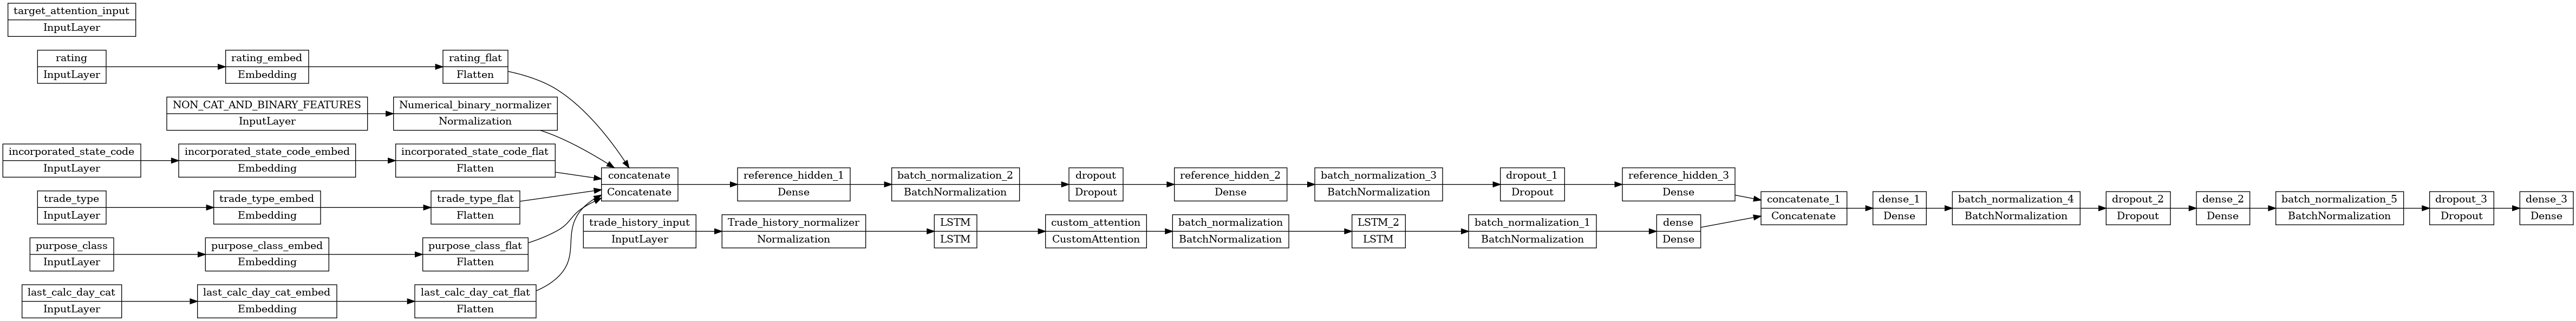

In [37]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [38]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [39]:
fit_callbacks = [
#     WandbCallback(),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True,
    ),
    time_callback
]

In [40]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [41]:
%%time 
history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=BATCH_SIZE, 
                    verbose=1, 
                    validation_split=0.01, 
                    callbacks=fit_callbacks,
                    use_multiprocessing=True,
                    workers=8)

Epoch 1/100
2607/2607 [==============================] - 41s 14ms/step - loss: 0.0689 - accuracy: 0.9778 - val_loss: 0.0165 - val_accuracy: 0.9953
Epoch 2/100
2607/2607 [==============================] - 35s 13ms/step - loss: 0.0282 - accuracy: 0.9900 - val_loss: 0.0148 - val_accuracy: 0.9953
Epoch 3/100
2607/2607 [==============================] - 36s 14ms/step - loss: 0.0253 - accuracy: 0.9908 - val_loss: 0.0145 - val_accuracy: 0.9954
Epoch 4/100
2607/2607 [==============================] - 35s 13ms/step - loss: 0.0238 - accuracy: 0.9912 - val_loss: 0.0127 - val_accuracy: 0.9958
Epoch 5/100
2607/2607 [==============================] - 34s 13ms/step - loss: 0.0227 - accuracy: 0.9915 - val_loss: 0.0125 - val_accuracy: 0.9954
Epoch 6/100
2607/2607 [==============================] - 35s 13ms/step - loss: 0.0219 - accuracy: 0.9917 - val_loss: 0.0124 - val_accuracy: 0.9955
Epoch 7/100
2607/2607 [==============================] - 35s 13ms/step - loss: 0.0212 - accuracy: 0.9919 - val_loss: 0

#### Plotting train vs validation loss

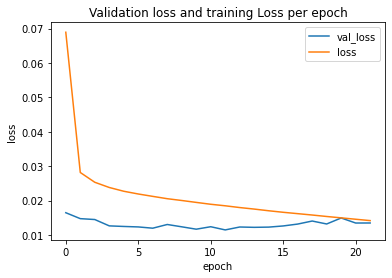

In [42]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Gigaflops for one epoch of training

In [43]:
avg_time = np.mean(time_callback.times)

In [44]:
n = len(x_train[0])
p = model.count_params()
avg_time = np.mean(time_callback.times)
gflops = ((n*p*2*3)/avg_time)/10**9

print(gflops)

137.8987959034346


### Test accuracy on the entire test set

In [45]:
_, mae = model.evaluate(x_test, y_test, verbose=1)
print(f"Test loss: {round(mae, 3)}")
# wandb.log({"Test MAE": mae})

812/812 [==============================] - 4s 5ms/step - loss: 0.0452 - accuracy: 0.9819
Test loss: 0.982


### Accuracy on a daily basis

Measuring the daily accuracy for large dealer dealer trades

In [46]:
for d in [d for d in pd.date_range(start="07/01/2022",end="07/10/2022",freq='D')]:
    next_day = test_dataframe[(test_dataframe.trade_date == d)
                              & (test_dataframe.trade_type == 'D')
                             & (test_dataframe.quantity >= np.log10(500000))].copy()
    if len(next_day) == 0:
        continue
    next_day_test = create_input(next_day)  
    next_day_preds = model.predict(next_day_test)
    error = next_day.calc_day_cat == np.argmax(next_day_preds, axis=-1)
    accuracy = np.mean(error)
    print(f"Date :{d.date()} Accuracy:{100.0 * accuracy}% of {len(next_day.calc_day_cat)} predictions" )

Date :2022-07-01 Accuracy:95.45454545454545% of 132 predictions
Date :2022-07-05 Accuracy:98.71244635193133% of 233 predictions


### Test accuracy on large dealer-dealer trades
We define large as any trade which is above $500,000

In [47]:
true_mid = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))] #& (test_dataframe.days_to_call >= np.log10(360))]

In [48]:
# true_mid = true_mid[true_mid.trade_date > '12-15-2021']

In [49]:
len(true_mid)

365

In [50]:
%%time
x_true_mid = create_input(true_mid)
y_true_mid = to_categorical(true_mid.calc_day_cat, num_classes=4)

CPU times: user 3.75 ms, sys: 0 ns, total: 3.75 ms
Wall time: 3.43 ms


In [51]:
_, mae = model.evaluate(x_true_mid, y_true_mid, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

12/12 [==============================] - 0s 5ms/step - loss: 0.0418 - accuracy: 0.9753
Test MAE: 0.975


### Alternative evaluation set
Experiment with other conditions. From the error analysis notebook, it was observed that the number of accrued days that have passed since the beginning of interest being accrued is important

In [52]:
temp_test = test_dataframe[(test_dataframe['accrued_days'] < 200)]

In [53]:
len(temp_test)

1776

In [54]:
%%time
x_temp_test = create_input(temp_test)
y_temp_test = to_categorical(temp_test.calc_day_cat, num_classes=4)

CPU times: user 7.92 ms, sys: 0 ns, total: 7.92 ms
Wall time: 7.59 ms


In [55]:
_, mae = model.evaluate(x_temp_test, y_temp_test, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

56/56 [==============================] - 0s 4ms/step - loss: 0.0513 - accuracy: 0.9820
Test MAE: 0.982


# Trained model error analysis

In [56]:
unprocessed_test_dataframe = data[data.trade_date >= '07-01-2022']

logits = model.predict(x_test)
prediction = np.argmax(logits, axis=-1)
successes = prediction == test_dataframe.calc_day_cat
success_dataframe = unprocessed_test_dataframe[successes]
failures = prediction != test_dataframe.calc_day_cat
failure_dataframe = unprocessed_test_dataframe[failures]

print(f"Test accuracy for the model is {np.count_nonzero(successes) / successes.shape[0]}")

Test accuracy for the model is 0.9819021948402002


In [65]:
next_par_errors = ((prediction == 0) & (test_dataframe.calc_day_cat == 1)) | ((prediction == 1) & (test_dataframe.calc_day_cat == 0))
rtrs = test_dataframe[next_par_errors].rtrs_control_number
next_par_df = data.loc[data['rtrs_control_number'].isin(rtrs)]
print(f'{np.count_nonzero(next_par_df.next_call_date == next_par_df.par_call_date)} out of {len(next_par_df)} next/par-call date mismatches were for the same date')
print(f'{np.count_nonzero(abs(next_par_df.next_call_date - next_par_df.par_call_date).dt.days <= 365)} out of {len(next_par_df)} next/par-call date mismatches were within one year')

mat_par_errors = ((prediction == 2) & (test_dataframe.calc_day_cat == 1)) | ((prediction == 1) & (test_dataframe.calc_day_cat == 2))
rtrs = test_dataframe[mat_par_errors].rtrs_control_number
mat_par_df = data.loc[data['rtrs_control_number'].isin(rtrs)]
print(f'{np.count_nonzero(mat_par_df.maturity_date == mat_par_df.par_call_date)} out of {len(mat_par_df)} maturity/par-call date mismatches were for the same date')
print(f'{np.count_nonzero(abs(next_par_df.maturity_date - next_par_df.par_call_date).dt.days <= 365)} out of {len(next_par_df)} maturity/par-call date mismatches were within one year')

mat_refund_errors = ((prediction == 2) & (test_dataframe.calc_day_cat == 3)) | ((prediction == 3) & (test_dataframe.calc_day_cat == 2))
rtrs = test_dataframe[mat_refund_errors].rtrs_control_number
mat_refund_df = data.loc[data['rtrs_control_number'].isin(rtrs)]
print(f'{np.count_nonzero(mat_refund_df.maturity_date == mat_refund_df.refund_date)} out of {len(mat_refund_df)} maturity/refund date mismatches were for the same date')
print(f'{np.count_nonzero(abs(next_par_df.maturity_date - next_par_df.refund_date).dt.days <= 365)} out of {len(next_par_df)} maturity/refund date mismatches were within one year')

mat_next_errors = ((prediction == 2) & (test_dataframe.calc_day_cat == 0)) | ((prediction == 0) & (test_dataframe.calc_day_cat == 2))
rtrs = test_dataframe[mat_next_errors].rtrs_control_number
mat_next_df = data.loc[data['rtrs_control_number'].isin(rtrs)]
print(f'{np.count_nonzero(mat_next_df.maturity_date == mat_next_df.next_call_date)} out of {len(mat_next_df)} maturity/next-call date mismatches were for the same date')
print(f'{np.count_nonzero(abs(next_par_df.maturity_date - next_par_df.next_call_date).dt.days <= 365)} out of {len(next_par_df)} maturity/next-call date mismatches were within one year')

0 out of 4 next/par-call date mismatches were for the same date
4 out of 4 next/par-call date mismatches were within one year
0 out of 2 maturity/par-call date mismatches were for the same date
0 out of 4 maturity/par-call date mismatches were within one year
0 out of 0 maturity/refund date mismatches were for the same date
0 out of 4 maturity/refund date mismatches were within one year
0 out of 464 maturity/next-call date mismatches were for the same date
0 out of 4 maturity/next-call date mismatches were within one year


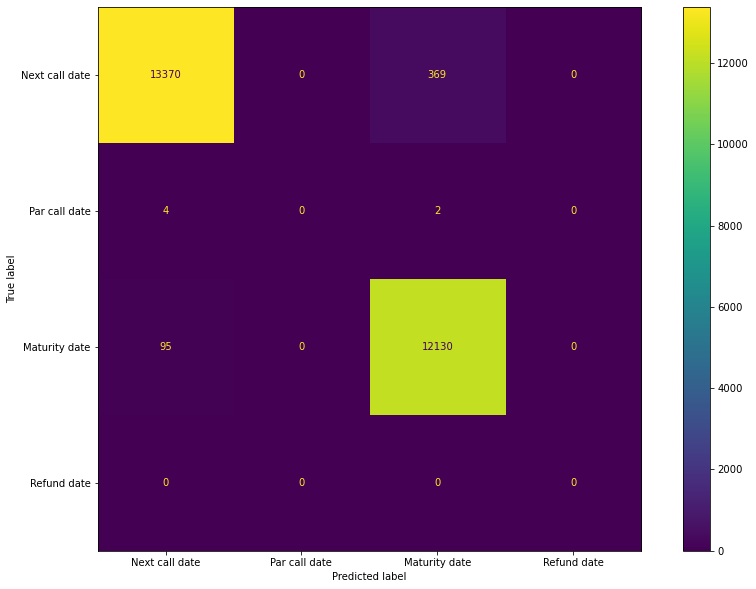

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(15, 10))
ConfusionMatrixDisplay.from_predictions(
    test_dataframe.calc_day_cat, 
    prediction, 
    labels=[0,1,2,3],
    display_labels=['Next call date', 'Par call date', 'Maturity date', 'Refund date'],
    ax=ax)
plt.show()

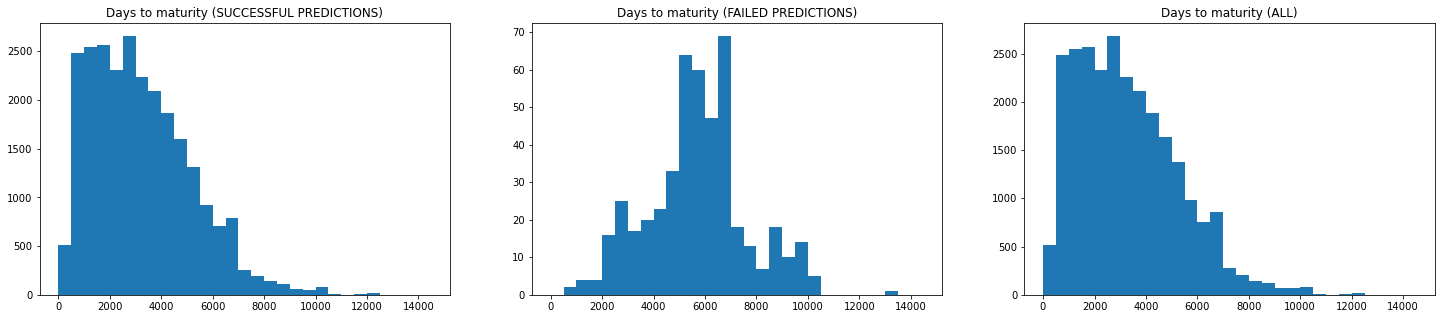

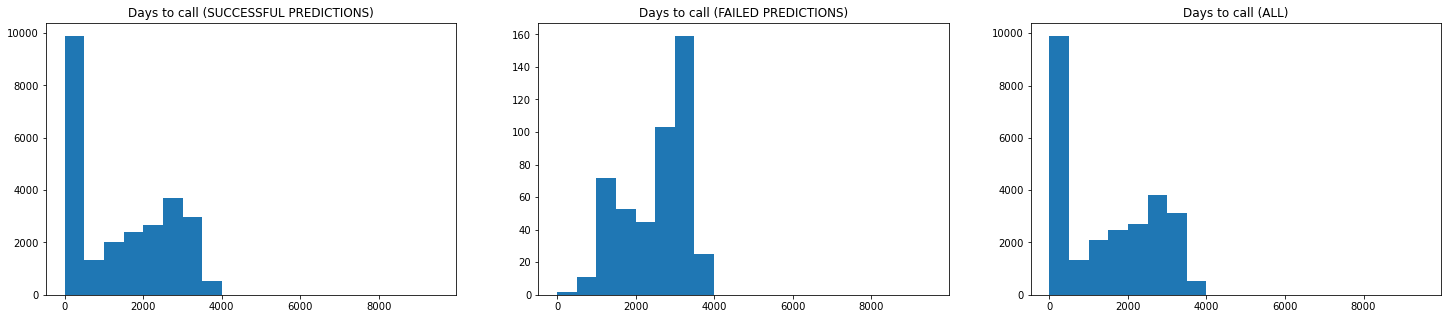

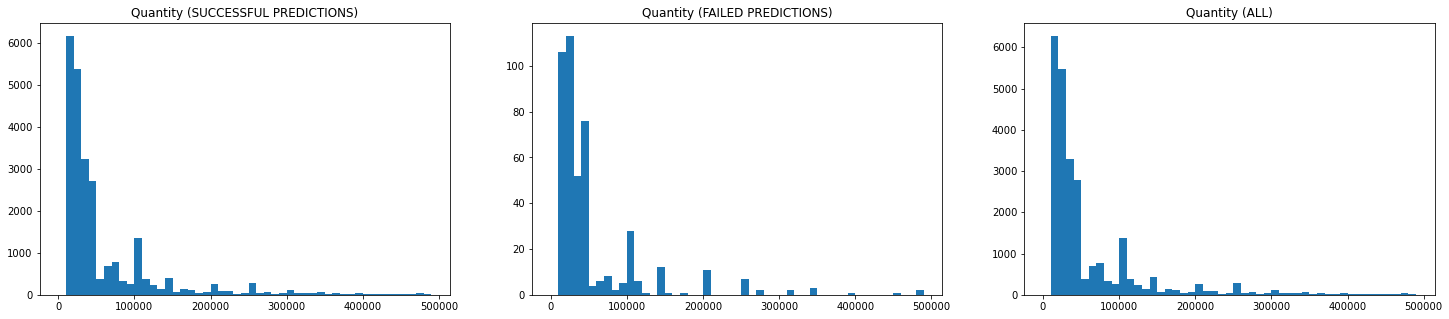

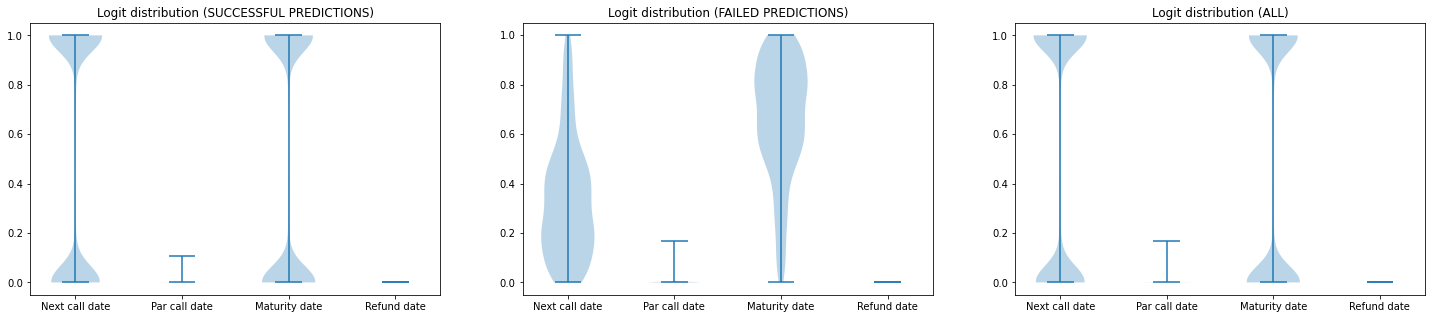

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(10.0 ** success_dataframe.days_to_maturity, bins=range(0, 15000, 500))
ax[0].set_title('Days to maturity (SUCCESSFUL PREDICTIONS)')
ax[1].hist(10.0 ** failure_dataframe.days_to_maturity, bins=range(0, 15000, 500))
ax[1].set_title('Days to maturity (FAILED PREDICTIONS)')
ax[2].hist(10.0 ** unprocessed_test_dataframe.days_to_maturity, bins=range(0, 15000, 500))
ax[2].set_title('Days to maturity (ALL)')
plt.show()
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(10.0 ** success_dataframe.days_to_call, bins=range(0, 10000, 500))
ax[0].set_title('Days to call (SUCCESSFUL PREDICTIONS)')
ax[1].hist(10.0 ** failure_dataframe.days_to_call, bins=range(0, 10000, 500))
ax[1].set_title('Days to call (FAILED PREDICTIONS)')
ax[2].hist(10.0 ** unprocessed_test_dataframe.days_to_call, bins=range(0, 10000, 500))
ax[2].set_title('Days to call (ALL)')
plt.show()
# Days to Settle/Refund didn't show differences, so they were removed
if 'last_dollar_price' in data.columns:
    fig, ax = plt.subplots(1, 3, figsize=(25, 5))
    ax[0].hist(success_dataframe.last_dollar_price, bins=range(30, 130, 2))
    ax[0].set_title('Last dollar price (SUCCESSFUL PREDICTIONS)')
    ax[0].axvline(100.0, color='r', linestyle='--')
    ax[1].hist(failure_dataframe.last_dollar_price, bins=range(30, 130, 2))
    ax[1].set_title('Last dollar price (FAILED PREDICTIONS)')
    ax[1].axvline(100.0, color='r', linestyle='--')
    ax[2].hist(unprocessed_test_dataframe.last_dollar_price, bins=range(30, 130, 2))
    ax[2].set_title('Last dollar price (ALL)')
    ax[2].axvline(100.0, color='r', linestyle='--')
    plt.show()
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(10.0 ** success_dataframe.quantity, bins=range(0, 500000, 10000))
ax[0].set_title('Quantity (SUCCESSFUL PREDICTIONS)')
ax[1].hist(10.0 ** failure_dataframe.quantity, bins=range(0, 500000, 10000))
ax[1].set_title('Quantity (FAILED PREDICTIONS)')
ax[2].hist(10.0 ** unprocessed_test_dataframe.quantity, bins=range(0, 500000, 10000))
ax[2].set_title('Quantity (ALL)')
plt.show()
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].violinplot(dataset=logits[successes],positions=range(4))
ax[0].set_title('Logit distribution (SUCCESSFUL PREDICTIONS)')
ax[0].set_xticks(range(4))
ax[0].set_xticklabels(['Next call date', 'Par call date', 'Maturity date', 'Refund date'])
ax[1].violinplot(dataset=logits[failures],positions=range(4))
ax[1].set_title('Logit distribution (FAILED PREDICTIONS)')
ax[1].set_xticks(range(4))
ax[1].set_xticklabels(['Next call date', 'Par call date', 'Maturity date', 'Refund date'])
ax[2].violinplot(dataset=logits,positions=range(4))
ax[2].set_title('Logit distribution (ALL)')
ax[2].set_xticks(range(4))
ax[2].set_xticklabels(['Next call date', 'Par call date', 'Maturity date', 'Refund date'])
plt.show()

# Saving the model

In [ ]:
save_model = False

if save_model:
    tf.get_logger().setLevel('ERROR')
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    file_timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')
    print(f"file time stamp : {file_timestamp}")

    print("Saving encoders and uploading encoders")
    with open(f"encoders_{file_timestamp}.pkl",'wb') as file:
        pickle.dump(encoders,file)    
    upload_data(storage_client, 'ficc_encoders', f"encoders_{file_timestamp}.pkl")

    print("Saving and uploading model")
    model.save(f"saved_cd_model_{file_timestamp}")
    import shutil
    shutil.make_archive(f"cd_model_jul_with_last_cdc", 'zip', f"saved_cd_model_{file_timestamp}")
    upload_data(storage_client, 'ficc_training_data_latest', f"cd_model_jul_with_last_cdc.zip")

# Baseline model error analysis

In [ ]:
unprocessed_test_dataframe = data[(data.trade_date >= '07-01-2022')]
prediction = test_dataframe.last_calc_day_cat
successes = prediction == test_dataframe.calc_day_cat
success_dataframe = unprocessed_test_dataframe[successes]
failures = prediction != test_dataframe.calc_day_cat
failure_dataframe = unprocessed_test_dataframe[failures]

print(f"Test accuracy for baseline is {np.count_nonzero(successes) / successes.shape[0]}")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(15, 10))
ConfusionMatrixDisplay.from_predictions(
    test_dataframe.calc_day_cat, 
    prediction, 
    labels=[0,1,2,3],
    display_labels=['Next call date', 'Par call date', 'Maturity date', 'Refund date'],
    ax=ax)
plt.show()

In [ ]:
next_par_errors = ((prediction == 0) & (test_dataframe.calc_day_cat == 1)) | ((prediction == 1) & (test_dataframe.calc_day_cat == 0))
rtrs = test_dataframe[next_par_errors].rtrs_control_number
next_par_df = data.loc[data['rtrs_control_number'].isin(rtrs)]
print(f'{np.count_nonzero(next_par_df.next_call_date == next_par_df.par_call_date)} out of {len(next_par_df)} next/par-call date mismatches were for the same date')

mat_par_errors = ((prediction == 2) & (test_dataframe.calc_day_cat == 1)) | ((prediction == 1) & (test_dataframe.calc_day_cat == 2))
rtrs = test_dataframe[mat_par_errors].rtrs_control_number
mat_par_df = data.loc[data['rtrs_control_number'].isin(rtrs)]
print(f'{np.count_nonzero(mat_par_df.maturity_date == mat_par_df.par_call_date)} out of {len(mat_par_df)} maturity/par-call date mismatches were for the same date')

mat_refund_errors = ((prediction == 2) & (test_dataframe.calc_day_cat == 3)) | ((prediction == 3) & (test_dataframe.calc_day_cat == 2))
rtrs = test_dataframe[mat_refund_errors].rtrs_control_number
mat_refund_df = data.loc[data['rtrs_control_number'].isin(rtrs)]
print(f'{np.count_nonzero(mat_refund_df.maturity_date == mat_refund_df.refund_date)} out of {len(mat_refund_df)} maturity/refund date mismatches were for the same date')

mat_next_errors = ((prediction == 2) & (test_dataframe.calc_day_cat == 0)) | ((prediction == 0) & (test_dataframe.calc_day_cat == 2))
rtrs = test_dataframe[mat_next_errors].rtrs_control_number
mat_next_df = data.loc[data['rtrs_control_number'].isin(rtrs)]
print(f'{np.count_nonzero(mat_next_df.maturity_date == mat_next_df.next_call_date)} out of {len(mat_next_df)} maturity/next-call date mismatches were for the same date')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(10.0 ** success_dataframe.days_to_maturity, bins=range(0, 15000, 500))
ax[0].set_title('Days to maturity (SUCCESSFUL PREDICTIONS)')
ax[1].hist(10.0 ** failure_dataframe.days_to_maturity, bins=range(0, 15000, 500))
ax[1].set_title('Days to maturity (FAILED PREDICTIONS)')
ax[2].hist(10.0 ** unprocessed_test_dataframe.days_to_maturity, bins=range(0, 15000, 500))
ax[2].set_title('Days to maturity (ALL)')
plt.show()
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(10.0 ** success_dataframe.days_to_call, bins=range(0, 10000, 500))
ax[0].set_title('Days to call (SUCCESSFUL PREDICTIONS)')
ax[1].hist(10.0 ** failure_dataframe.days_to_call, bins=range(0, 10000, 500))
ax[1].set_title('Days to call (FAILED PREDICTIONS)')
ax[2].hist(10.0 ** unprocessed_test_dataframe.days_to_call, bins=range(0, 10000, 500))
ax[2].set_title('Days to call (ALL)')
plt.show()
# Days to Settle/Refund didn't show differences, so they were removed
if 'last_dollar_price' in data.columns:
    fig, ax = plt.subplots(1, 3, figsize=(25, 5))
    ax[0].hist(success_dataframe.last_dollar_price, bins=range(30, 130, 2))
    ax[0].set_title('Last dollar price (SUCCESSFUL PREDICTIONS)')
    ax[0].axvline(100.0, color='r', linestyle='--')
    ax[1].hist(failure_dataframe.last_dollar_price, bins=range(30, 130, 2))
    ax[1].set_title('Last dollar price (FAILED PREDICTIONS)')
    ax[1].axvline(100.0, color='r', linestyle='--')
    ax[2].hist(unprocessed_test_dataframe.last_dollar_price, bins=range(30, 130, 2))
    ax[2].set_title('Last dollar price (ALL)')
    ax[2].axvline(100.0, color='r', linestyle='--')
    plt.show()
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(10.0 ** success_dataframe.quantity, bins=range(0, 500000, 10000))
ax[0].set_title('Quantity (SUCCESSFUL PREDICTIONS)')
ax[1].hist(10.0 ** failure_dataframe.quantity, bins=range(0, 500000, 10000))
ax[1].set_title('Quantity (FAILED PREDICTIONS)')
ax[2].hist(10.0 ** unprocessed_test_dataframe.quantity, bins=range(0, 500000, 10000))
ax[2].set_title('Quantity (ALL)')
plt.show()

In [ ]:
numeric_differences = []
binary_differences = []
for failure in failure_dataframe.iterrows():
    pre_failure = data[(data.cusip == failure[1].cusip) 
                        & (data.trade_datetime < failure[1].trade_datetime) 
                        & (data.calc_day_cat == failure[1].last_calc_day_cat) 
                        ]
    if len(pre_failure) > 0:
        numeric_differences.append(failure[1][NON_CAT_FEATURES] - pre_failure.iloc[-1, :][NON_CAT_FEATURES])
        binary_differences.append(failure[1][BINARY] - pre_failure.iloc[-1, :][BINARY].astype('float32'))

In [ ]:
numeric_differences_df = pd.concat(numeric_differences, axis=1)
binary_differences_df = pd.concat(binary_differences, axis=1)

In [ ]:
for feat in NON_CAT_FEATURES:
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.violinplot(dataset=numeric_differences_df.loc[feat, :].astype(float),positions=range(1))
    ax.set_title(feat)
    plt.show()
for feat in BINARY:
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.violinplot(dataset=binary_differences_df.loc[feat, :].astype(float),positions=range(1))
    ax.set_title(feat + "BINARY")
    plt.show()

In [ ]:
for row in failure_dataframe.iterrows():
    print(row[1].rtrs_control_number, row[1].cusip)

In [ ]:
import catboost
from catboost.utils import get_gpu_device_count

def prep_input(df):
    x = df[NON_CAT_FEATURES + BINARY + CATEGORICAL_FEATURES].copy()
    for col in BINARY:
        if x[col].dtype == 'category':
            x[col] = x[col].astype('bool')
    x.purpose_class = x.purpose_class.astype('int32')
    return x

model = catboost.CatBoostClassifier(
    random_seed=10,
    depth=12,           # Max depth of a tree
    iterations=1000,    # Max number of trees in the forest
    task_type="GPU" if get_gpu_device_count() > 0 else "CPU",   # Use GPU if available
)
model.fit(X=prep_input(train_dataframe), y=train_dataframe.calc_day_cat != train_dataframe.last_calc_day_cat, cat_features=CATEGORICAL_FEATURES, plot=True, silent=True)

model.save_model('calc_date_misprediction_estimator_10iter.cbm')


In [ ]:
test_labels = (test_dataframe.calc_day_cat != test_dataframe.last_calc_day_cat).astype('string')
print(f"Test accuracy is {model.score(X=prep_input(test_dataframe), y=test_labels)}")

predictions_while_false = model.predict(prep_input(test_dataframe[test_dataframe.calc_day_cat == test_dataframe.last_calc_day_cat])) == 'True'
print(f"{np.count_nonzero(predictions_while_false)} trades are predicted as mismatching, when they actually match")
print(f"False positive rate is {np.count_nonzero(predictions_while_false) / len(predictions_while_false)} of the {len(predictions_while_false)} matches.")

predictions_while_true = model.predict(prep_input(test_dataframe[test_dataframe.calc_day_cat != test_dataframe.last_calc_day_cat])) == 'True'
print(f"{len(predictions_while_true) - np.count_nonzero(predictions_while_true)} trades are predicted as matching, when they actually mismatch")
print(f"False negative rate is {(len(predictions_while_true) - np.count_nonzero(predictions_while_true)) / len(predictions_while_true)} of the {len(predictions_while_true)} mismatches.")

prediction_probs_while_true = model.predict_proba(prep_input(test_dataframe[test_dataframe.calc_day_cat != test_dataframe.last_calc_day_cat]))
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(prediction_probs_while_true[:, 1], bins=100)
ax.set_title('Probability when there is a mismatch')
plt.show()

print(f"{1.0 - (np.count_nonzero(predictions_while_false) + len(predictions_while_true) - np.count_nonzero(predictions_while_true)) / len(test_labels)} is the accuracy of the model")

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(prep_input(test_dataframe).columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
inputs = []
layer = []

############## INPUT BLOCK ###################
trade_history_input = layers.Input(name="trade_history_input", 
                                   shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                   dtype = tf.float32) 

target_attention_input = layers.Input(name="target_attention_input", 
                                   shape=(SEQUENCE_LENGTH, 3), 
                                   dtype = tf.float32) 


inputs.append(trade_history_input)
inputs.append(target_attention_input)

inputs.append(layers.Input(
    name="NON_CAT_AND_BINARY_FEATURES",
    shape=(len(NON_CAT_FEATURES + BINARY),)
))


layer.append(noncat_binary_normalizer(inputs[2]))
####################################################


############## TRADE HISTORY MODEL #################

# Adding the time2vec encoding to the input to transformer
lstm_layer = layers.LSTM(50, 
                         activation='tanh',
                         input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                         kernel_initializer = layer_initializer,
                         return_sequences = True,
                         name='LSTM')

# lstm_attention_layer = layers.Attention(use_scale=True, name='attention_layer_1')
lstm_attention_layer = CustomAttention(50)

lstm_layer_2 = layers.LSTM(100, 
                           activation='tanh',
                           input_shape=(SEQUENCE_LENGTH,50),
                           kernel_initializer = layer_initializer,
                           return_sequences = False,
                           name='LSTM_2')


features = lstm_layer(trade_history_normalizer(inputs[0]))
# features = lstm_attention_layer([features, features])
features = lstm_attention_layer(features, features, inputs[1])
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

features = lstm_layer_2(features)
features = layers.BatchNormalization()(features)
# features = layers.Dropout(DROPOUT)(features)

trade_history_output = layers.Dense(100, 
                                    activation='relu',
                                    kernel_initializer=layer_initializer)(features)

####################################################

############## REFERENCE DATA MODEL ################
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                    output_dim = int(np.sqrt(fmax[f])),
                                                                    input_length= 1,
                                                                    name = f + "_embed",
                                                                    embeddings_initializer=layer_initializer)(fin))
    layer.append(embedded)

    
reference_hidden = layers.Dense(400,activation='relu',kernel_initializer=layer_initializer,name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

reference_hidden = layers.BatchNormalization()(reference_hidden)
reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

reference_hidden2 = layers.Dense(200,activation='relu',kernel_initializer=layer_initializer,name='reference_hidden_2')(reference_hidden)
reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

reference_output = layers.Dense(100,activation='tanh',kernel_initializer=layer_initializer,name='reference_hidden_3')(reference_hidden2)

####################################################

feed_forward_input = layers.concatenate([reference_output, trade_history_output])

hidden = layers.Dense(300,activation='relu',kernel_initializer=layer_initializer)(feed_forward_input)
hidden = layers.BatchNormalization()(hidden)
hidden = layers.Dropout(DROPOUT)(hidden)

hidden2 = layers.Dense(100,activation='tanh',kernel_initializer=layer_initializer)(hidden)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(DROPOUT)(hidden2)

final = layers.Dense(1,kernel_initializer=layer_initializer, activation='sigmoid')(hidden2)

model = keras.Model(inputs=inputs, outputs=final)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

history = model.fit(x_train, 
                    train_dataframe.calc_day_cat != train_dataframe.last_calc_day_cat, 
                    epochs=10, 
                    batch_size=BATCH_SIZE, 
                    verbose=1, 
                    validation_split=0.1, 
                    # callbacks=fit_callbacks,
                    use_multiprocessing=True,
                    workers=8)

plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
_, acc = model.evaluate(x_test, test_dataframe.calc_day_cat != test_dataframe.last_calc_day_cat, verbose=1)
print(f"Test accuracy: {round(acc, 3)}")

In [ ]:
predictions = model.predict(x_test).squeeze()

results = (predictions > 0.1) == (test_dataframe.calc_day_cat != test_dataframe.last_calc_day_cat)
print(results.shape)
print(f"Test accuracy with 0.1 threshold: {round(np.count_nonzero(results) / len(results), 3)}")

results = (predictions > 0.5) == (test_dataframe.calc_day_cat != test_dataframe.last_calc_day_cat)
print(f"Test accuracy with 0.5 threshold: {round(np.count_nonzero(results) / len(results), 3)}")

results = (predictions > 0.9) == (test_dataframe.calc_day_cat != test_dataframe.last_calc_day_cat)
print(f"Test accuracy with 0.9 threshold: {round(np.count_nonzero(results) / len(results), 3)}")

In [ ]:
predictions_while_false = model.predict(create_input(test_dataframe[test_dataframe.calc_day_cat == test_dataframe.last_calc_day_cat])).squeeze() > 0.9
print(f"{np.count_nonzero(predictions_while_false)} trades are predicted as mismatching, when they actually match")
print(f"False positive rate is {np.count_nonzero(predictions_while_false) / len(predictions_while_false)} of the {len(predictions_while_false)} matches.")

predictions_while_true = model.predict(create_input(test_dataframe[test_dataframe.calc_day_cat != test_dataframe.last_calc_day_cat])).squeeze() > 0.1
print(f"{len(predictions_while_true) - np.count_nonzero(predictions_while_true)} trades are predicted as matching, when they actually mismatch")
print(f"False negative rate is {(len(predictions_while_true) - np.count_nonzero(predictions_while_true)) / len(predictions_while_true)} of the {len(predictions_while_true)} mismatches.")

prediction_probs_while_true = model.predict(create_input(test_dataframe[test_dataframe.calc_day_cat != test_dataframe.last_calc_day_cat])).squeeze()
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(prediction_probs_while_true, bins=100)
ax.set_title('Probability when there is a mismatch')
plt.show()

print(f"{1.0 - (np.count_nonzero(predictions_while_false) + len(predictions_while_true) - np.count_nonzero(predictions_while_true)) / len(test_labels)} is the accuracy of the model")